In [58]:
#!pip install numpy scipy matplotlib seaborn scikit-learn mesa==3.0.3 -q

In [59]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.time import RandomActivation
import mesa

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import matplotlib.lines as lines

import pandas as pd
import seaborn as sns
import numpy as np
import random
import heapq
from enum import Enum
from collections import defaultdict


sns.set()
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['figure.figsize'] = (5, 5)

In [60]:
wall_type = [0, 1, 2, 3, 4] # 0: none, 1: wall 1hp, 2: wall 2hp, 3: open door
                              # 4: closed door

grid_layout = [[(2, 0, 2, 2), (2, 0, 2, 0), (2, 4, 2, 0), (2, 0, 0, 4), (2, 0, 0, 0), (2, 2, 0, 0), (2, 0, 0, 2), (2, 2, 0, 0)],
               [(2, 0, 0, 2), (2, 0, 0, 0), (2, 2, 0, 0), (0, 0, 2, 2), (0, 0, 2, 0), (0, 4, 4, 0), (0, 0, 0, 4), (0, 2, 0, 0)],
               [(0, 0, 0, 3), (0, 0, 2, 0), (0, 2, 0, 0), (2, 0, 0, 2), (2, 0, 0, 0), (4, 2, 0, 0), (0, 0, 0, 2), (0, 2, 0, 0)],
               [(0, 2, 4, 2), (2, 2, 0, 2), (0, 2, 0, 2), (0, 0, 2, 2), (0, 0, 0, 0), (0, 2, 0, 0), (0, 0, 2, 2), (0, 2, 2, 0)],
               [(4, 0, 0, 2), (0, 2, 0, 0), (0, 0, 2, 2), (2, 3, 2, 0), (0, 0, 4, 3), (0, 3, 2, 0), (2, 0, 0, 3), (2, 3, 0, 0)],
               [(0, 0, 2, 2), (0, 0, 2, 0), (2, 0, 2, 0), (2, 0, 2, 0), (4, 0, 2, 0), (2, 2, 2, 0), (0, 0, 2, 2), (0, 2, 2, 0)]
               ]

grid_data = np.array(grid_layout)


In [61]:
class FireState(Enum):
  CLEAR = 0
  SMOKE = 1
  FIRE = 2

class POIType(Enum):
  VICTIM = "victim"
  FALSE = "false_alarm"

class POI:
  def __init__(self, poi_id, poi_type, x, y):
    self.id = poi_id
    self.type = poi_type
    self.x = x
    self.y = y
    self.revealed = False

In [62]:
class FireAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(model)
        self.action_points = 4
        self.carrying_victim = None
        self.knockout_timer = 0
        self.max_knockout_time = 2
        self.unique_id = unique_id

    def reset_ap(self):
        self.action_points = 4

    def is_knocked_out(self):
        return self.knockout_timer > 0

    def update_knockout(self):
        if self.knockout_timer > 0:
            self.knockout_timer -= 1
            if self.knockout_timer == 0:
                self.action_points = 4
                self.respawn_agent()

    def respawn_agent(self):
        if self.carrying_victim:
            self.carrying_victim = None

        new_position = self.find_valid_respawn_position()
        if new_position:
            self.model.grid.move_agent(self, new_position)

    def find_valid_respawn_position(self):
        valid_positions = []
        for y in range(self.model.height):
            for x in range(self.model.width):
                if self.model._get_fire_state(x, y) == FireState.CLEAR:
                    if not any(poi.x == x and poi.y == y for poi in self.model.active_pois):
                        valid_positions.append((x, y))

        if valid_positions:
            return random.choice(valid_positions)
        return None

    def check_knockout(self):
        if self.pos and not self.is_knocked_out():
            fire_state = self.model._get_fire_state(self.pos[0], self.pos[1])
            if fire_state == FireState.FIRE:
                self.knockout_timer = self.max_knockout_time

    def step(self):
        self.reset_ap()
        self.update_knockout()

        if self.is_knocked_out():
            return

        # Random movement behavior with action management
        while self.action_points > 0:
            self.handle_current_cell()

            if self.action_points <= 0:
                break

            if not self.random_move():
                self.handle_current_cell()
                break

        self.check_knockout()

    def handle_current_cell(self):
        x, y = self.pos

        # Check if at exit with victim
        exits = [(0, 2), (7, 4)]
        if self.carrying_victim and (x, y) in exits:
            rescued_victim = self.carrying_victim
            self.carrying_victim = None
            self.model.rescue_victims(rescued_victim)
            self.action_points -= 1
            return

        # Check for POI at current position
        poi = self.model._get_poi_at_position(x, y)
        if poi and not poi.revealed and self.action_points > 0:
            self.reveal_and_handle_poi(poi)
            return

        # Handle fire/smoke at current position
        fire_state = self.model._get_fire_state(x, y)
        if fire_state in [FireState.FIRE, FireState.SMOKE] and self.action_points > 0:
            self.extinguish_fire(x, y)

    def reveal_and_handle_poi(self, poi):
        if self.action_points > 0:
            reveal_success = self.model.reveal_poi(poi.x, poi.y)
            if reveal_success:
                if poi.type == POIType.VICTIM and poi not in self.model.lost_victims:
                    self.carrying_victim = poi
                    if poi in self.model.active_pois:
                        self.model.active_pois.remove(poi)

                    new_poi = self.model.place_new_poi()

            self.action_points -= 1

    def random_move(self):
        if self.action_points <= 0:
            return False

        directions = [(0, -1), (1, 0), (0, 1), (-1, 0)]  # up, right, down, left
        random.shuffle(directions)

        for dx, dy in directions:
            new_x = self.pos[0] + dx
            new_y = self.pos[1] + dy

            if not (0 <= new_x < self.model.width and 0 <= new_y < self.model.height):
                continue

            wall_type, wall_dir = self.model._get_wall_between_cells(
                self.pos[0], self.pos[1], new_x, new_y
            )

            if wall_type == 0 or wall_type == 3:
                cost = 1
            elif wall_type == 4:
                cost = 1
            else:
                continue

            if self.action_points >= cost:
                if wall_type == 4:
                    self.open_door(self.pos[0], self.pos[1], wall_dir)

                self.model.grid.move_agent(self, (new_x, new_y))
                self.action_points -= cost

                if self.carrying_victim:
                    self.carrying_victim.x = new_x
                    self.carrying_victim.y = new_y

                return True

        return False

    def extinguish_fire(self, x, y):
        fire_state = self.model._get_fire_state(x, y)

        if fire_state == FireState.FIRE:
            if self.action_points >= 2:
                self.action_points -= 2
                self.model._set_fire_state(x, y, FireState.CLEAR)
            elif self.action_points >= 1:
                self.action_points -= 1
                self.model._set_fire_state(x, y, FireState.SMOKE)
        elif fire_state == FireState.SMOKE:
            if self.action_points >= 1:
                self.action_points -= 1
                self.model._set_fire_state(x, y, FireState.CLEAR)

    def open_door(self, x, y, direction):
        if self.action_points >= 1 and 0 <= x < self.model.width and 0 <= y < self.model.height:
            if self.model.grid_data[y, x, direction] == 4:
                self.model.grid_data[y, x, direction] = 3
                self.action_points -= 1

In [63]:
class FireRescueModel(Model):
  def __init__(self, grid_data, max_steps=1000):
    super().__init__()
    self.grid_data = grid_data.copy()
    height, width = grid_data.shape[:2]
    self.height = height
    self.width = width

    self.max_steps = max_steps
    self.step_counter = 0

    self.grid = MultiGrid(width, height, torus=False)
    self.running = True
    self.fire_states = np.full((height, width), FireState.CLEAR)
    self.step_count = 0
    self.damage_count = 0

    self.all_pois = []
    self.active_pois = []
    self.revealed_pois = []
    self.lost_victims = []
    self.rescued_victims = []
    self.pois_lost = []

    self.current_agent_index = 0
    self.agent_list = []
    self.round_count = 0
    self.phase = "AGENT_TURN"

    self.game_over = False
    self.game_won = False
    self.game_lost = False
    self.end_reason = ""

    self._create_poi_pool()
    self._place_initial_pois()
    self._place_initial_fires()
    self.place_firefighters()

  def _create_poi_pool(self):
    poi_id = 1
    for i in range(10):
      poi = POI(poi_id, POIType.VICTIM, -1, -1)
      self.all_pois.append(poi)
      poi_id += 1

    for i in range(5):
      poi = POI(poi_id, POIType.FALSE, -1, -1)
      self.all_pois.append(poi)
      poi_id += 1

    random.shuffle(self.all_pois)

  def _get_valid_positions_for_poi(self):
    valid_positions = []
    for y in range(self.height):
      for x in range(self.width):
        if any(poi.x == x and poi.y == y for poi in self.active_pois):
          continue
        valid_positions.append((x, y))
    return valid_positions

  def _place_initial_pois(self):
    valid_positions = self._get_valid_positions_for_poi()

    if len(self.all_pois) == 0 or len(valid_positions) == 0:
      return

    num_pois = min(3, len(self.all_pois), len(valid_positions))
    initial_pois = random.sample(self.all_pois, num_pois)
    selected_positions = random.sample(valid_positions, num_pois)

    for poi, (x, y) in zip(initial_pois, selected_positions):
      poi.x = x
      poi.y = y
      self.active_pois.append(poi)

    for poi in initial_pois:
      self.all_pois.remove(poi)

  def _get_poi_at_position(self, x, y):
    for poi in self.active_pois:
      if poi.x == x and poi.y == y:
        return poi
    return None

  def place_new_poi(self):
    if len(self.all_pois) == 0:
      return None

    valid_positions = self._get_valid_positions_for_poi()
    if len(valid_positions) == 0:
      return None

    new_poi = random.choice(self.all_pois)
    selected_position = random.choice(valid_positions)

    new_poi.x = selected_position[0]
    new_poi.y = selected_position[1]
    self.fire_states[new_poi.y, new_poi.x] = FireState.CLEAR
    self.active_pois.append(new_poi)
    self.all_pois.remove(new_poi)

    return new_poi

  def reveal_poi(self, x, y):
    for poi in self.active_pois:
      if poi.x == x and poi.y == y and not poi.revealed:
        poi.revealed = True
        self.revealed_pois.append(poi)

        if poi.type == POIType.VICTIM:
          print(f"Es una victima.")
        elif poi.type == POIType.FALSE:
          print(f"Es una falsa alarma.")
          self.active_pois.remove(poi)
          self.place_new_poi()

        return True
    return False

  def rescue_victims(self, victim_poi):
    if victim_poi.type == POIType.VICTIM:
      self.rescued_victims.append(victim_poi)
      if victim_poi in self.active_pois:
        self.active_pois.remove(victim_poi)
      self.check_win_condition()

  def check_pois_in_danger(self):
    for poi in self.active_pois[:]:
      fire_state = self._get_fire_state(poi.x, poi.y)
      if fire_state == FireState.FIRE:
        if poi.type == POIType.VICTIM:
          self.lost_victims.append(poi)
        self.active_pois.remove(poi)
        self.pois_lost.append(poi)
        self.place_new_poi()

    if len(self.lost_victims) >= 4:
      self.end_game(False, f"Derrota: {len(self.lost_victims)} victimas perdidas por fuego")

    return self.pois_lost

  def _place_initial_fires(self):
    self.fire_states[1, 3] = FireState.FIRE
    self.fire_states[0, 7] = FireState.FIRE
    self.fire_states[3, 1] = FireState.FIRE

  def spread_fire_random(self):
    x = random.randint(0, self.width - 1)
    y = random.randint(0, self.height - 1)

    current_state = self._get_fire_state(x, y)

    if current_state == FireState.CLEAR:
      self._set_fire_state(x, y, FireState.SMOKE)
    elif current_state == FireState.SMOKE:
      self._set_fire_state(x, y, FireState.FIRE)
    elif current_state == FireState.FIRE:
      adjacent_cells = self._get_adjacent_cells(x, y)

      for adj in adjacent_cells:
        ax, ay = adj['pos']
        wall_type = adj['wall_type']
        wall_dir = adj['wall_dir']

        can_pass = self.damage_wall(ax, ay, wall_dir)

        if can_pass:
          adj_state = self._get_fire_state(ax, ay)

          if adj_state == FireState.CLEAR:
            self._set_fire_state(ax, ay, FireState.FIRE)
          elif adj_state == FireState.SMOKE:
            self._set_fire_state(ax, ay, FireState.FIRE)

  def spread_smoke_to_fire(self):
    fire_positions = []
    for y in range(self.height):
      for x in range(self.width):
        if self._get_fire_state(x, y) == FireState.FIRE:
          fire_positions.append((x, y))

    smoke_to_convert = []
    for fx, fy in fire_positions:
      adjacent_cells = self._get_adjacent_cells(fx, fy)
      for adj in adjacent_cells:
        ax, ay = adj['pos']
        wall_type = adj['wall_type']
        if (self._get_fire_state(ax, ay) == FireState.SMOKE and wall_type == 0):
          smoke_to_convert.append((ax, ay))

    for sx, sy in smoke_to_convert:
      self._set_fire_state(sx, sy, FireState.FIRE)

  def _get_fire_state(self, x, y):
    return self.fire_states[y, x]

  def _set_fire_state(self, x, y, state):
    self.fire_states[y, x] = state

  def place_firefighters(self):
    valid_positions = []

    for y in range(self.height):
      for x in range(self.width):
        if self.fire_states[y, x] != FireState.CLEAR:
          continue

        if any(poi.x == x and poi.y == y for poi in self.active_pois):
          continue

        valid_positions.append((x, y))

    selected_positions = random.sample(valid_positions, 6)
    for i, pos in enumerate(selected_positions):
      firefighter = FireAgent(i, self)
      self.grid.place_agent(firefighter, pos)
      self.agent_list.append(firefighter)

  def get_current_agent(self):
    if not self.agent_list:
      return None
    return self.agent_list[self.current_agent_index]

  def agent_turn(self):
    current_agent = self.get_current_agent()
    if current_agent is None:
      self.phase = "FIRE_SPREAD"
      return

    print(f"\n-- Agent {current_agent.unique_id} Turn ---")
    current_agent.step()

    self.current_agent_index = (self.current_agent_index + 1) % len(self.agent_list)
    self.phase = "FIRE_SPREAD"
    if self.current_agent_index == 0:
      self.round_count += 1

    self.step_count += 1

  def fire_spread_phase(self):
    print(f"\n-- FIRE SPREAD PHASE (Round {self.round_count}) ---")
    self.spread_fire_random()
    self.spread_smoke_to_fire()
    lost_pois = self.check_pois_in_danger()
    if lost_pois:
      victims_lost = sum(1 for p in lost_pois if p.type == POIType.VICTIM)
      alarms_destroyed = sum(1 for p in lost_pois if p.type == POIType.FALSE)
      print(f"¡{victims_lost} víctimas y {alarms_destroyed} falsas alarmas perdidas por fuego!")
    self.step_count += 1
    self.phase = "AGENT_TURN"
    print(f"Contador de daño: {self.damage_count}")

  def _get_adjacent_cells(self, x, y):
    adjacent = []
    directions = [(0, -1), (1, 0), (0, 1), (-1, 0)]
    for i, (dx, dy) in enumerate(directions):
      nx, ny = x + dx, y + dy
      if 0 <= nx < self.width and 0 <= ny < self.height:
        wall_type, wall_dir = self._get_wall_between_cells(x, y, nx, ny)
        adjacent.append({
          'pos': (nx, ny),
          'wall_type': wall_type,
          'wall_dir': wall_dir,
          'source_pos': (x, y)
        })
    return adjacent

  def _get_wall_between_cells(self, x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1

    if dx == 0 and dy == -1:
      direction = 0
    elif dx == 1 and dy == 0:
      direction = 1
    elif dx == 0 and dy == 1:
      direction = 2
    elif dx == -1 and dy == 0:
      direction = 3
    else:
      return 0, -1

    if 0 <= x1 < self.width and 0 <= y1 < self.height:
      wall_type = self.grid_data[y1, x1, direction]
      return wall_type, direction
    else:
      return 0, -1

  def damage_wall(self, x, y, direction):
    if 0 <= x < self.width and 0 <= y < self.height:
      current_wall = self.grid_data[y, x, direction]
      if current_wall == 2:
        print(f"Muro grueso dañado en ({x}, {y}), contador de daño: {self.damage_count}")
        self.grid_data[y, x, direction] = 1
        self.damage_count += 1
        self.check_damage_loss_condition()
        return False
      elif current_wall == 1:
        print(f"Muro destruido en ({x}, {y}), contador de daño: {self.damage_count}")
        self.check_damage_loss_condition()
        return True
      elif current_wall in [3, 4]:
        self.grid_data[y, x, direction] = 0
        return True
      else:
        return True

  def check_damage_loss_condition(self):
    if self.damage_count > 24:
      self.end_game(False, "Derrota: Demasiados daños")

  def check_win_condition(self):
    if len(self.rescued_victims) >= 7:
      self.end_game(True, "Victoria: 7 victimas rescatadas")

  def end_game(self, won, reason):
    self.game_over = True
    self.game_won = won
    self.game_lost = not won
    self.end_reason = reason
    self.running = False

    print(f"JUEGO TERMINADO")
    print(f"{'='*50}")
    print(f"Resultado: {reason}")
    print(f"Estadísticas finales:")
    print(f"- Víctimas rescatadas: {len(self.rescued_victims)}/7")
    print(f"- Víctimas perdidas: {len(self.lost_victims)}/4")
    print(f"- Daño estructural: {self.damage_count}/24")
    print(f"- Rounds jugados: {self.round_count}")

    fire_count = np.sum(self.fire_states == FireState.FIRE)
    smoke_count = np.sum(self.fire_states == FireState.SMOKE)
    clear_count = np.sum(self.fire_states == FireState.CLEAR)
    print(f"- Celdas de fuego: {fire_count}")
    print(f"- Celdas de humo: {smoke_count}")
    print(f"- Celdas limpias: {clear_count}")
    print(f"{'='*50}")

  def is_game_over(self):
    return self.game_over

  def step(self):
    self.step_counter += 1
    if self.step_counter > self.max_steps:
      self.end_game(False, "Max Steps Alcanzados")
      return

    if self.phase == "AGENT_TURN":
      self.agent_turn()
    elif self.phase == "FIRE_SPREAD":
      self.fire_spread_phase()

  def get_final_statistics(self):
    fire_count = np.sum(self.fire_states == FireState.FIRE)
    smoke_count = np.sum(self.fire_states == FireState.SMOKE)
    clear_count = np.sum(self.fire_states == FireState.CLEAR)

    return {
      'game_won': self.game_won,
      'game_lost': self.game_lost,
      'end_reason': self.end_reason,
      'rescued_victims': len(self.rescued_victims),
      'lost_victims': len(self.lost_victims),
      'damage_count': self.damage_count,
      'rounds_played': self.round_count,
      'steps_taken': self.step_counter,
      'fire_cells': fire_count,
      'smoke_cells': smoke_count,
      'clear_cells': clear_count,
      'total_pois_lost': len(self.pois_lost),
      'false_alarms_destroyed': sum(1 for p in self.pois_lost if p.type == POIType.FALSE),
      'active_pois_remaining': len(self.active_pois)
    }

In [64]:
model = FireRescueModel(grid_data, max_steps=1000)
rows = model.height
cols = model.width

In [65]:
def get_wall_visual_style(wall_type):
  if wall_type == 0:
    return None, 0, '-'
  elif wall_type == 1:
    return 'black', 2, '-'
  elif wall_type == 2:
    return 'black', 4, '-'
  elif wall_type == 3:
    return 'green', 4, '--'
  elif wall_type == 4:
    return 'red', 4, '-'

fig, ax = plt.subplots(figsize=(cols, rows))

def draw_grid(ax, model):
  ax.clear()
  ax.set_xlim(0, cols)
  ax.set_ylim(0, rows)
  ax.set_aspect('equal', adjustable='box')
  ax.invert_yaxis()

  border_color = 'lightblue'
  border_width = 6
  ax.add_line(lines.Line2D([0, cols], [0, 0], color=border_color, linewidth=border_width))
  ax.add_line(lines.Line2D([0, cols], [rows, rows], color=border_color, linewidth=border_width))
  ax.add_line(lines.Line2D([0, 0], [0, rows], color=border_color, linewidth=border_width))
  ax.add_line(lines.Line2D([cols, cols], [0, rows], color=border_color, linewidth=border_width))

  exits = [(0, 2), (7, 4)]
  for exit_x, exit_y in exits:
    if 0 <= exit_x < cols and 0 <= exit_y < rows:
      exit_rect = patches.Rectangle(
          (exit_x, exit_y), 1, 1,
          facecolor='lightpink',
          edgecolor='black',
          linewidth=0.5,
          alpha=0.8,
          zorder = 1
      )
      ax.add_patch(exit_rect)

  for y in range(rows):
    for x in range(cols):
      fire_state = model._get_fire_state(x, y)

      if fire_state == FireState.CLEAR:
        face_color = 'lightgray'
        alpha = 0.7
      elif fire_state == FireState.SMOKE:
        face_color = 'darkgray'
        alpha = 0.8
      elif fire_state == FireState.FIRE:
        face_color = 'orange'
        alpha = 0.9

      rect = patches.Rectangle(
          (x, y), 1, 1,
          facecolor=face_color,
          edgecolor='black',
          linewidth=0.5,
          alpha=alpha,
          zorder = 2
      )
      ax.add_patch(rect)

      walls = model.grid_data[y][x]

      wall_positions = [([x, x + 1], [y, y]),
                        ([x + 1, x + 1], [y, y + 1]),
                        ([x, x + 1], [y + 1, y + 1]),
                        ([x, x], [y, y + 1])]

      for i, wall_type in enumerate(walls):
        color, linewidth, linestyle = get_wall_visual_style(wall_type)
        if color is not None:
          x_coords, y_coords = wall_positions[i]

          if linestyle == '--':
            line = lines.Line2D(
                x_coords, y_coords,
                color=color,
                linewidth=linewidth,
                linestyle=linestyle,
                dashes=[2,2],
                zorder = 5
              )
          else:
            line = lines.Line2D(
                x_coords, y_coords,
                color=color,
                linewidth=linewidth,
                linestyle=linestyle,
                zorder = 5
              )
          ax.add_line(line)

  ax.set_xticks(range(cols + 1))
  ax.set_yticks(range(rows + 1))
  ax.grid(True, alpha=0.2, color='blue')

  for agent in model.agent_list:
    if agent.carrying_victim:
      agent_color = 'lightblue'
    else:
      agent_color = 'red'

    if agent.is_knocked_out():
      agent_alpha = 0.2
    else:
      agent_alpha = 0.9

    ax.scatter(agent.pos[0] + 0.5, agent.pos[1] + 0.5,
              color=agent_color,
              s=450,
              marker='^',
              edgecolors='black',
              linewidth=2,
              alpha=agent_alpha,
              zorder=8)

    ax.text(agent.pos[0] + 0.5, agent.pos[1] + 0.5, str(agent.unique_id),
            ha='center', va='center',
            color='white', fontweight='bold', fontsize=10, zorder=9)

  for poi in model.active_pois:
    marker = 'o'
    size = 300
    if not poi.revealed:
      color = 'yellow'
      alpha = 0.9
    else:
      if poi.type == POIType.VICTIM:
        color = 'purple'
        alpha = 1.0

    ax.scatter(poi.x + 0.5, poi.y + 0.5,
              color=color,
              s=size,
              marker=marker,
              edgecolors='black',
              linewidth=2,
              alpha=alpha,
              zorder=10)

    ax.text(poi.x + 0.5, poi.y + 0.5, str(poi.id),
            ha='center', va='center',
            color='black', fontweight='bold', fontsize=8,
            zorder=11)

draw_grid(ax, model)

def animate(i):
  while model.running:
    draw_grid(ax, model)
    model.step()
    return []

anim = animation.FuncAnimation(fig, animate, frames=300, interval=100)
plt.show()
anim

Output hidden; open in https://colab.research.google.com to view.

Streaming output truncated to the last 5000 lines.

-- FIRE SPREAD PHASE (Round 3) ---
¡0 víctimas y 1 falsas alarmas perdidas por fuego!
Contador de daño: 2

-- Agent 5 Turn ---

-- FIRE SPREAD PHASE (Round 4) ---
¡0 víctimas y 1 falsas alarmas perdidas por fuego!
Contador de daño: 2

-- Agent 0 Turn ---

-- FIRE SPREAD PHASE (Round 4) ---
¡0 víctimas y 1 falsas alarmas perdidas por fuego!
Contador de daño: 2

-- Agent 1 Turn ---

-- FIRE SPREAD PHASE (Round 4) ---
¡0 víctimas y 1 falsas alarmas perdidas por fuego!
Contador de daño: 2

-- Agent 2 Turn ---

-- FIRE SPREAD PHASE (Round 4) ---
Muro destruido en (6, 5), contador de daño: 2
¡0 víctimas y 1 falsas alarmas perdidas por fuego!
Contador de daño: 2

-- Agent 3 Turn ---

-- FIRE SPREAD PHASE (Round 4) ---
¡0 víctimas y 1 falsas alarmas perdidas por fuego!
Contador de daño: 2

-- Agent 4 Turn ---

-- FIRE SPREAD PHASE (Round 4) ---
¡0 víctimas y 1 falsas alarmas perdidas por fuego!
Contador de daño: 2

-- Agent 5 Turn ---

-- FIR

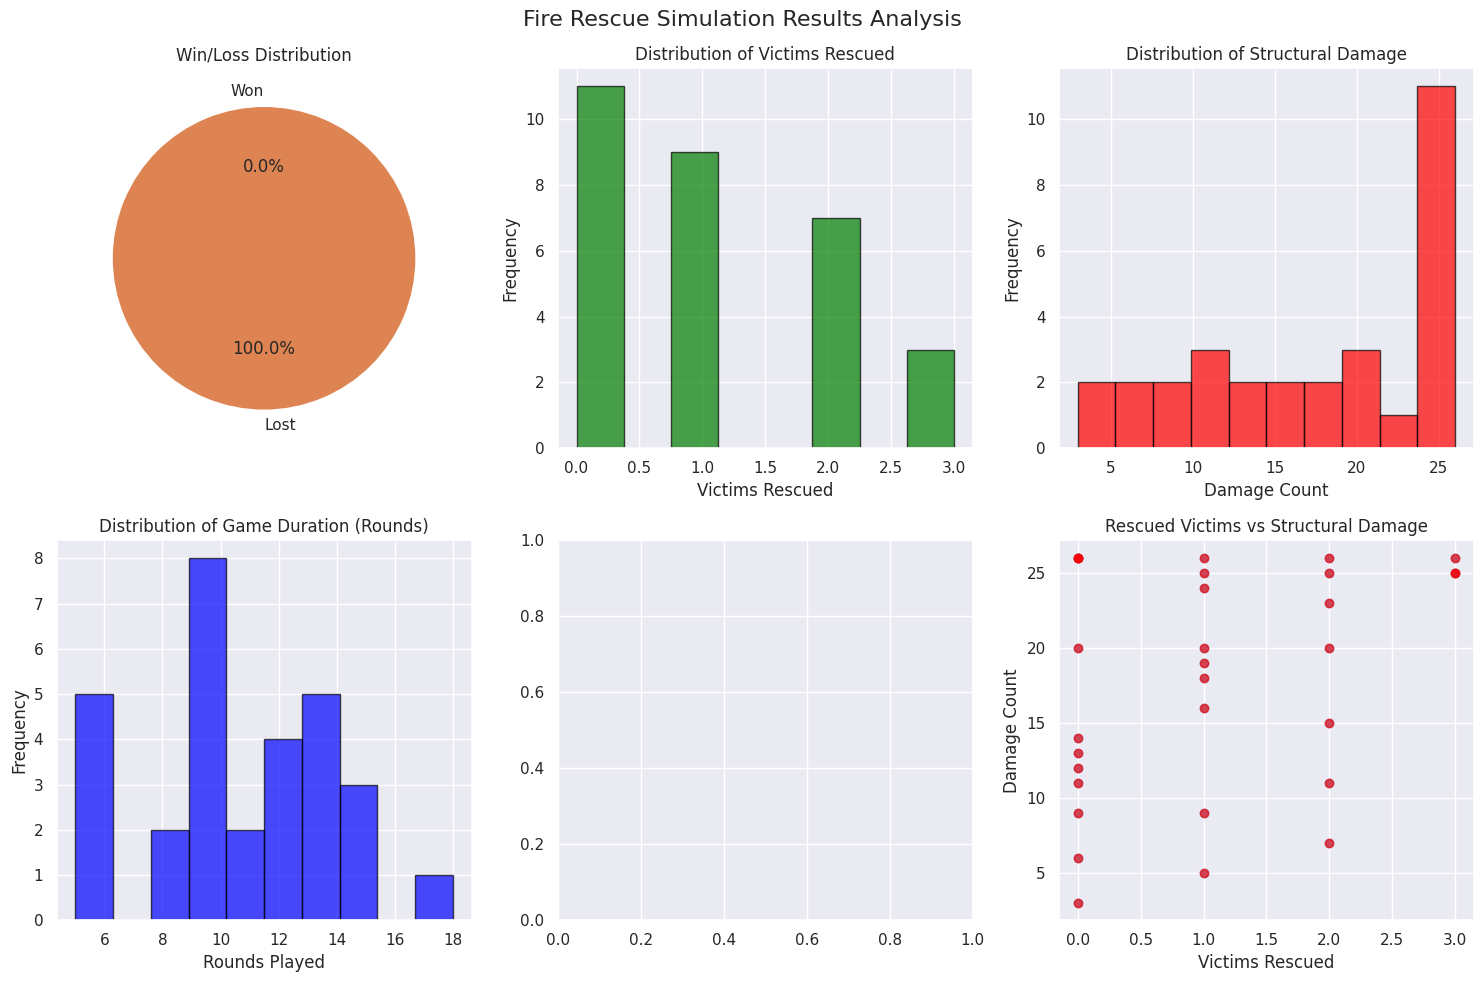

In [66]:
class BatchSimulationResults:
    def __init__(self):
        self.results = []

    def add_result(self, result):
        self.results.append(result)

    def get_summary_statistics(self):
        """Calculate comprehensive summary statistics"""
        if not self.results:
            return {}

        df = pd.DataFrame(self.results)

        # Win/Loss statistics
        total_games = len(self.results)
        games_won = sum(1 for r in self.results if r['game_won'])
        games_lost = total_games - games_won
        win_rate = games_won / total_games * 100

        # Loss reasons breakdown
        loss_reasons = defaultdict(int)
        for result in self.results:
            if result['game_lost']:
                loss_reasons[result['end_reason']] += 1

        # Basic statistics
        stats = {
            'total_games': total_games,
            'games_won': games_won,
            'games_lost': games_lost,
            'win_rate_percent': round(win_rate, 2),
            'loss_reasons': dict(loss_reasons)
        }

        # Calculate means and standard deviations for key metrics
        numeric_columns = [
            'rescued_victims', 'lost_victims', 'damage_count', 'rounds_played',
            'steps_taken', 'fire_cells', 'smoke_cells', 'clear_cells',
            'total_pois_lost', 'false_alarms_destroyed', 'active_pois_remaining'
        ]

        for col in numeric_columns:
            values = [r[col] for r in self.results]
            stats[f'avg_{col}'] = round(np.mean(values), 2)
            stats[f'std_{col}'] = round(np.std(values), 2)
            stats[f'min_{col}'] = min(values)
            stats[f'max_{col}'] = max(values)

        return stats

    def print_detailed_summary(self):
        stats = self.get_summary_statistics()

        print("=" * 80)
        print("FIRE RESCUE BATCH SIMULATION RESULTS")
        print("=" * 80)

        print(f"\nOVERALL PERFORMANCE:")
        print(f"  Total Games Played: {stats['total_games']}")
        print(f"  Games Won: {stats['games_won']} ({stats['win_rate_percent']}%)")
        print(f"  Games Lost: {stats['games_lost']} ({100-stats['win_rate_percent']}%)")

        print(f"\nLOSS BREAKDOWN:")
        for reason, count in stats['loss_reasons'].items():
            percentage = (count / stats['total_games']) * 100
            print(f"  {reason}: {count} games ({percentage:.1f}%)")

        print(f"\nVICTIM STATISTICS:")
        print(f"  Average Victims Rescued: {stats['avg_rescued_victims']} ± {stats['std_rescued_victims']}")
        print(f"  Range: {stats['min_rescued_victims']} - {stats['max_rescued_victims']}")
        print(f"  Average Victims Lost: {stats['avg_lost_victims']} ± {stats['std_lost_victims']}")
        print(f"  Range: {stats['min_lost_victims']} - {stats['max_lost_victims']}")

        print(f"\nSTRUCTURAL DAMAGE:")
        print(f"  Average Damage: {stats['avg_damage_count']} ± {stats['std_damage_count']}")
        print(f"  Range: {stats['min_damage_count']} - {stats['max_damage_count']}")

        print(f"\nGAME DURATION:")
        print(f"  Average Rounds: {stats['avg_rounds_played']} ± {stats['std_rounds_played']}")
        print(f"  Range: {stats['min_rounds_played']} - {stats['max_rounds_played']}")
        print(f"  Average Steps: {stats['avg_steps_taken']} ± {stats['std_steps_taken']}")
        print(f"  Range: {stats['min_steps_taken']} - {stats['max_steps_taken']}")

        print(f"\nFIRE SPREAD:")
        print(f"  Average Fire Cells: {stats['avg_fire_cells']} ± {stats['std_fire_cells']}")
        print(f"  Range: {stats['min_fire_cells']} - {stats['max_fire_cells']}")
        print(f"  Average Smoke Cells: {stats['avg_smoke_cells']} ± {stats['std_smoke_cells']}")
        print(f"  Range: {stats['min_smoke_cells']} - {stats['max_smoke_cells']}")
        print(f"  Average Clear Cells: {stats['avg_clear_cells']} ± {stats['std_clear_cells']}")
        print(f"  Range: {stats['min_clear_cells']} - {stats['max_clear_cells']}")

        print(f"\nPOI STATISTICS:")
        print(f"  Average POIs Lost: {stats['avg_total_pois_lost']} ± {stats['std_total_pois_lost']}")
        print(f"  Range: {stats['min_total_pois_lost']} - {stats['max_total_pois_lost']}")
        print(f"  Average False Alarms Destroyed: {stats['avg_false_alarms_destroyed']} ± {stats['std_false_alarms_destroyed']}")
        print(f"  Range: {stats['min_false_alarms_destroyed']} - {stats['max_false_alarms_destroyed']}")

        print("=" * 80)

    def create_results_dataframe(self):
        """Convert results to pandas DataFrame for further analysis"""
        return pd.DataFrame(self.results)

def run_single_simulation(simulation_id=0, max_steps=1000):
    print(f"\n{'='*50}")
    print(f"SIMULATION {simulation_id + 1}")
    print(f"{'='*50}")

    model = FireRescueModel(grid_data.copy(), max_steps=max_steps)

    while model.running:
        model.step()

    results = model.get_final_statistics()
    results['simulation_id'] = simulation_id

    print(f"\nSimulation {simulation_id + 1} completed:")
    print(f"  Result: {'WON' if results['game_won'] else 'LOST'}")
    print(f"  Reason: {results['end_reason']}")
    print(f"  Victims Rescued: {results['rescued_victims']}")
    print(f"  Victims Lost: {results['lost_victims']}")
    print(f"  Damage: {results['damage_count']}")
    print(f"  Rounds: {results['rounds_played']}")

    return results

def run_batch_simulation(num_simulations=10, max_steps=1000):
    print(f"Starting batch simulation with {num_simulations} runs...")
    print(f"Maximum steps per simulation: {max_steps}")
    print("-" * 50)

    batch_results = BatchSimulationResults()

    for i in range(num_simulations):
        # Set different random seed for each simulation
        random.seed(i * 1000 + 42)
        np.random.seed(i * 1000 + 42)

        try:
            result = run_single_simulation(i, max_steps=max_steps)
            batch_results.add_result(result)

            progress = (i + 1) / num_simulations * 100
            won_count = sum(1 for r in batch_results.results if r['game_won'])
            print(f"Progress: {i+1:2d}/{num_simulations} ({progress:5.1f}%) | "
                  f"Wins: {won_count:2d} | "
                  f"Current Win Rate: {won_count/(i+1)*100:5.1f}%")

        except Exception as e:
            print(f"Error in simulation {i+1}: {str(e)}")
            continue

    print("\n" + "="*50)
    print("BATCH SIMULATION COMPLETED")
    print("="*50)

    # Print detailed summary
    batch_results.print_detailed_summary()

    return batch_results

def analyze_win_factors(batch_results):
  df = batch_results.create_results_dataframe()

  won_games = df[df['game_won'] == True]
  lost_games = df[df['game_won'] == False]

  print("\n" + "="*50)
  print("WIN FACTOR ANALYSIS")
  print("="*50)

  if len(won_games) > 0 and len(lost_games) > 0:
    print(f"\nCOMPARISON BETWEEN WON AND LOST GAMES:")

    metrics = ['rescued_victims', 'lost_victims', 'damage_count', 'rounds_played',
              'fire_cells', 'smoke_cells', 'clear_cells']

    for metric in metrics:
      won_avg = won_games[metric].mean()
      lost_avg = lost_games[metric].mean()
      difference = won_avg - lost_avg

      print(f"\n{metric.replace('_', ' ').title()}:")
      print(f"  Won games average:  {won_avg:.2f}")
      print(f"  Lost games average: {lost_avg:.2f}")
      print(f"  Difference:         {difference:+.2f}")

  print("\n" + "="*50)

def create_performance_plots(batch_results):
      df = batch_results.create_results_dataframe()

      fig, axes = plt.subplots(2, 3, figsize=(15, 10))
      fig.suptitle('Fire Rescue Simulation Results Analysis', fontsize=16)

      # Plot 1: Win/Loss distribution
      win_counts = [sum(df['game_won']), sum(~df['game_won'])]
      axes[0, 0].pie(win_counts, labels=['Won', 'Lost'], autopct='%1.1f%%', startangle=90)
      axes[0, 0].set_title('Win/Loss Distribution')

      # Plot 2: Victims rescued distribution
      axes[0, 1].hist(df['rescued_victims'], bins=8, alpha=0.7, color='green', edgecolor='black')
      axes[0, 1].set_title('Distribution of Victims Rescued')
      axes[0, 1].set_xlabel('Victims Rescued')
      axes[0, 1].set_ylabel('Frequency')

      # Plot 3: Damage distribution
      axes[0, 2].hist(df['damage_count'], bins=10, alpha=0.7, color='red', edgecolor='black')
      axes[0, 2].set_title('Distribution of Structural Damage')
      axes[0, 2].set_xlabel('Damage Count')
      axes[0, 2].set_ylabel('Frequency')

      # Plot 4: Game duration
      axes[1, 0].hist(df['rounds_played'], bins=10, alpha=0.7, color='blue', edgecolor='black')
      axes[1, 0].set_title('Distribution of Game Duration (Rounds)')
      axes[1, 0].set_xlabel('Rounds Played')
      axes[1, 0].set_ylabel('Frequency')

      # Plot 5: Fire spread comparison
      won_games = df[df['game_won'] == True]
      lost_games = df[df['game_won'] == False]

      if len(won_games) > 0 and len(lost_games) > 0:
          x = np.arange(3)
          won_fire = [won_games['fire_cells'].mean(), won_games['smoke_cells'].mean(), won_games['clear_cells'].mean()]
          lost_fire = [lost_games['fire_cells'].mean(), lost_games['smoke_cells'].mean(), lost_games['clear_cells'].mean()]

          width = 0.35
          axes[1, 1].bar(x - width/2, won_fire, width, label='Won Games', alpha=0.7)
          axes[1, 1].bar(x + width/2, lost_fire, width, label='Lost Games', alpha=0.7)
          axes[1, 1].set_title('Average Cell States: Won vs Lost')
          axes[1, 1].set_xlabel('Cell Type')
          axes[1, 1].set_ylabel('Average Count')
          axes[1, 1].set_xticks(x)
          axes[1, 1].set_xticklabels(['Fire', 'Smoke', 'Clear'])
          axes[1, 1].legend()

      axes[1, 2].scatter(df['rescued_victims'], df['damage_count'], alpha=0.6)
      axes[1, 2].set_title('Rescued Victims vs Structural Damage')
      axes[1, 2].set_xlabel('Victims Rescued')
      axes[1, 2].set_ylabel('Damage Count')

      for i, row in df.iterrows():
          color = 'green' if row['game_won'] else 'red'
          axes[1, 2].scatter(row['rescued_victims'], row['damage_count'], color=color, alpha=0.6)

      plt.tight_layout()
      plt.show()

if __name__ == "__main__":
    print("Fire Rescue Batch Simulation")
    print("="*50)

    NUM_SIMULATIONS = 30
    MAX_STEPS = 1000

    results = run_batch_simulation(
        num_simulations=NUM_SIMULATIONS,
        max_steps=MAX_STEPS
    )

    analyze_win_factors(results)
    create_performance_plots(results)